In [12]:
%pip install flwr[simulation] torch torchvision matplotlib flwr-datasets[vision] torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [13]:


import json
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import flwr as fl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Parameters
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from torch.utils.data import DataLoader


if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Silicon GPU (MPS) for training.")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA GPU for training.")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU for training.")

print(f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}")

NUM_CLIENTS = 10
BATCH_SIZE = 32
NUM_ROUNDS = 4

NUM_EPOCHS = 5
NUM_PARTITIONS = NUM_CLIENTS
print(
    f"Number of clients: {NUM_CLIENTS}, BATCH_SIZE: {BATCH_SIZE}, NUM_ROUNDS: {NUM_ROUNDS}, NUM_EPOCHS: {NUM_EPOCHS}, NUM_PARTITIONS: {NUM_PARTITIONS}")

Using Apple Silicon GPU (MPS) for training.
Training on mps using PyTorch 2.7.1 and Flower 1.20.0
Number of clients: 10, BATCH_SIZE: 32, NUM_ROUNDS: 4, NUM_EPOCHS: 5, NUM_PARTITIONS: 10


Let's load the CIFAR-10 dataset and partition it.
Each partition will be assigned to a different client.
We will also apply class skewing to the data, so that some clients will have low entropy datasets, while others will have high entropy datasets.



In [14]:
def load_datasets(partition_id: int, num_partitions: int, skew_percentage: float = 0.6):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": num_partitions})
    partition = fds.load_partition(partition_id)

    # Divide data on each node: 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)

    # Determine how many clients should have skewed data
    num_skewed_clients = int(num_partitions * skew_percentage)

    # Apply class skewing to selected clients only
    if partition_id < num_skewed_clients:
        train_data = partition_train_test["train"]

        # Each skewed client gets 1-2 dominant classes
        if partition_id < num_skewed_clients // 2:
            # First half of skewed clients get single class (very low entropy)
            dominant_class = partition_id % 10
            train_data = train_data.filter(lambda x: x["label"] == dominant_class)
            print(f"Client {partition_id}: Training on class [{dominant_class}] (SKEWED - Low Entropy)")
        else:
            # Second half get two classes (medium entropy)
            class1 = (partition_id * 2) % 10
            class2 = (class1 + 1) % 10
            train_data = train_data.filter(lambda x: x["label"] in [class1, class2])
            print(f"Client {partition_id}: Training on classes [{class1}, {class2}] (SKEWED - Medium Entropy)")

        # Update the partition with skewed training data
        partition_train_test["train"] = train_data
    else:
        # These clients keep the normal data distribution (high entropy)
        print(f"Client {partition_id}: Training on all classes (NORMAL - High Entropy)")

    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        # Instead of passing transforms to CIFAR10(..., transform=transform)
        # we will use this function to dataset.with_transform(apply_transforms)
        # The transforms object is exactly the same
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)
    trainloader = DataLoader(
        partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True
    )

    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)
    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader


Let's define the neural network architecture.
This is a simple CNN with two convolutional layers followed by three fully connected layers.

In [15]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch + 1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"], batch["label"]
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

Let's define a function to compute the entropy of a dataset.
The entropy is computed for each column in the dataset, and then the average entropy is returned.

In [16]:
import pandas as pd
def _get_column_entropy_paper(column) -> float:
    counts = column.value_counts(dropna=False)
    total = counts.sum()
    probs = counts / total
    return -sum(np.log2(probs))
def _get_column_entropy(column) -> float:
    column_probability = column.value_counts(normalize=True, dropna=False)
    column_probability = column_probability[column_probability > 0]
    return -sum(column_probability * np.log2(column_probability))

def compute_entropy(dataset) -> float:
    dataset = pd.DataFrame(dataset)
    entropies = [_get_column_entropy_paper(dataset[column]) for column in dataset.columns]
    return np.mean(entropies)

In [17]:
class FlowerClient(NumPyClient):
    def __init__(self, partition_id, net, trainloader: DataLoader, valloader):
        self.partition_id = partition_id
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.partition_id}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.partition_id} fit, config: {config}")
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=NUM_EPOCHS)

        # Compute entropy of the training dataset
        entropy = compute_entropy(self.trainloader.dataset)

        return get_parameters(self.net), len(self.trainloader), {"entropy": float(entropy)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.partition_id}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:
    net = Net().to(DEVICE)

    # Read the node_config to fetch data partition associated to this node
    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()

client = ClientApp(client_fn=client_fn)

In [18]:

params = get_parameters(Net())
# The `evaluate` function will be called by Flower after every round
def evaluate(server_round: int, parameters: NDArrays, config: Dict[str, Scalar]) -> Optional[
    Tuple[float, Dict[str, Scalar]]]:
    net = Net().to(DEVICE)
    _, _, testloader = load_datasets(0, NUM_PARTITIONS)
    set_parameters(net, parameters)  # Update model with the latest parameters
    loss, accuracy = test(net, testloader)
    # Compute entropy of the test set
    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")
    return loss, {"accuracy": accuracy, "entropy": compute_entropy(testloader.dataset)}


In [19]:
# Vanilla FedAvg for comparison
class VanillaFedAvg(FedAvg):
    def __init__(self, file_name: str, num_rounds: int, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.file_name = file_name
        self.num_rounds = num_rounds
        self.loss_list = []
        self.metrics_list = []

    def evaluate(self, server_round: int, parameters: Parameters):
        loss, metrics = super().evaluate(server_round, parameters)

        if loss is not None and metrics is not None:
            # Store results
            self.loss_list.append(loss)
            self.metrics_list.append(metrics)

            print(f"Round {server_round} - Vanilla FedAvg:")
            print(f"  Loss: {loss:.4f}")
            print(f"  Accuracy: {metrics.get('accuracy', 0.0):.4f}")

            if server_round == self.num_rounds:
                with open(f"{self.file_name}_vanilla.json", "w") as f:
                    json.dump({"loss": self.loss_list, "metrics": self.metrics_list}, f)

            return loss, metrics
        # To prevent crash if evaluation returns None
        print(f"[Warning] Evaluation returned None at round {server_round}")
        return 0.0, {}

def server_fn_vanilla(context: Context) -> ServerAppComponents:
    """Server function for vanilla FedAvg strategy."""
    # Create the vanilla FedAvg strategy
    strategy = VanillaFedAvg(
        file_name="results_vanilla_fedavg",
        num_rounds=NUM_ROUNDS,
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=10,
        min_evaluate_clients=10,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,  # Pass the evaluation function
    )
    # Configure the server for training rounds
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)



In [20]:

from EntropyWeightedFedAvg import EntropyWeightedFedAvg

def server_fn_entropy(context: Context) -> ServerAppComponents:
    """Server function for vanilla FedAvg strategy."""
    # Create the vanilla FedAvg strategy
    strategy = EntropyWeightedFedAvg(
        file_name="results_vanilla_fedavg",
        num_rounds=NUM_ROUNDS,
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=10,
        min_evaluate_clients=10,
        min_available_clients=NUM_PARTITIONS,
        initial_parameters=ndarrays_to_parameters(params),
        evaluate_fn=evaluate,  # Pass the evaluation function
    )
    # Configure the server for training rounds
    config = ServerConfig(num_rounds=NUM_ROUNDS)
    return ServerAppComponents(strategy=strategy, config=config)

print("Running Entropy-weighted simulation...")
server_entropy = ServerApp(server_fn=server_fn_entropy)

run_simulation(
    server_app=server_entropy,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config={"client_resources": {"num_cpus": 10, "num_gpus": 0}},
)


INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout


Running Entropy-weighted simulation...


INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
(raylet) /opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
(raylet)   warnings.warn(


Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.07212880566120147 / accuracy 0.1009


INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 0 - Entropy-Weighted FedAvg:
  Loss: 0.0721
  Accuracy: 0.1009
(ClientAppActor pid=92206) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 0 fit, config: {}
(ClientAppActor pid=92206) Epoch 1: train loss 0.04973289743065834, accuracy 0.9105691056910569
(ClientAppActor pid=92206) Epoch 2: train loss 0.0005707626696676016, accuracy 1.0
(ClientAppActor pid=92206) Epoch 3: train loss 6.302764887777812e-08, accuracy 1.0
(ClientAppActor pid=92206) Epoch 4: train loss 5.552591164637022e-10, accuracy 1.0
(ClientAppActor pid=92206) Epoch 5: train loss 1.3124323849922348e-10, accuracy 1.0
(ClientAppActor pid=92206) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 1 fit, config: {}
(ClientAppActor pid=92206) Epoch 1: train loss 0.05402097851037979, accuracy 0.8789473684210526
(ClientAppActor pid=92206) Epoch 2: train loss 0.0009785216534510255, accuracy 1.0
(ClientAppActor pid=92206) Epoch 3: train loss 6.8623

INFO :      aggregate_fit: received 10 results and 0 failures


Client entropy: 3819.7652, weight: 3819.7652, examples: 25
Client entropy: 23948.1817, weight: 23948.1817, examples: 125
Client entropy: 1628.2726, weight: 1628.2726, examples: 12
Client entropy: 23948.1830, weight: 23948.1830, examples: 125
Client entropy: 3781.0259, weight: 3781.0259, examples: 25
Client entropy: 3742.3357, weight: 3742.3357, examples: 25
Client entropy: 23948.1826, weight: 23948.1826, examples: 125
Client entropy: 1814.7639, weight: 1814.7639, examples: 14
Client entropy: 1573.3195, weight: 1573.3195, examples: 12
Client entropy: 23948.1837, weight: 23948.1837, examples: 125
Round 1 - Entropy-weighted aggregation:
  Average entropy: 11215.2214
  Entropy range: [1573.3195, 23948.1837]
  Average weight: 11215.2214
Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.05634041912555694 / accuracy 0.355


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Round 1 - Entropy-Weighted FedAvg:
  Loss: 0.0563
  Accuracy: 0.3550
(ClientAppActor pid=92206) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 0] evaluate, config: {}
(ClientAppActor pid=92206) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 1] evaluate, config: {}
(ClientAppActor pid=92206) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 2] evaluate, config: {}
(ClientAppActor pid=92206) Client 3: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 3] evaluate, config: {}
(ClientAppActor pid=92206) Client 4: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 4] evaluate, config: {}
(ClientAppActor pid=92206) Client 5: Training on classes [0, 1] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 5] evaluate, config: {}
(ClientAppActor pid=92206) Client 6: Training on all classes 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=92206) Client 9: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=92206) [Client 9] evaluate, config: {}
(ClientAppActor pid=92206) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 0 fit, config: {}
(ClientAppActor pid=92206) Epoch 1: train loss 0.01559486985206604, accuracy 0.8943089430894309
(ClientAppActor pid=92206) Epoch 2: train loss 6.578260217793286e-05, accuracy 1.0
(ClientAppActor pid=92206) Epoch 3: train loss 2.3536900073395373e-07, accuracy 1.0
(ClientAppActor pid=92206) Epoch 4: train loss 3.304135987036716e-08, accuracy 1.0
(ClientAppActor pid=92206) Epoch 5: train loss 1.904587421108772e-08, accuracy 1.0
(ClientAppActor pid=92206) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 1 fit, config: {}
(ClientAppActor pid=92206) Epoch 1: train loss 0.016894420608878136, accuracy 0.8842105263157894
(ClientAppActor pid=92206) Epoch 2: train loss 6.26475957687

INFO :      aggregate_fit: received 10 results and 0 failures


Client entropy: 23948.1826, weight: 23948.1826, examples: 125
Client entropy: 23948.1830, weight: 23948.1830, examples: 125
Client entropy: 3819.7652, weight: 3819.7652, examples: 25
Client entropy: 3742.3357, weight: 3742.3357, examples: 25
Client entropy: 1814.7639, weight: 1814.7639, examples: 14
Client entropy: 23948.1837, weight: 23948.1837, examples: 125
Client entropy: 23948.1817, weight: 23948.1817, examples: 125
Client entropy: 1628.2726, weight: 1628.2726, examples: 12
Client entropy: 3781.0259, weight: 3781.0259, examples: 25
Client entropy: 1573.3195, weight: 1573.3195, examples: 12
Round 2 - Entropy-weighted aggregation:
  Average entropy: 11215.2214
  Entropy range: [1573.3195, 23948.1837]
  Average weight: 11215.2214
Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.04447008115649223 / accuracy 0.4914


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Round 2 - Entropy-Weighted FedAvg:
  Loss: 0.0445
  Accuracy: 0.4914
(ClientAppActor pid=92206) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 0] evaluate, config: {}
(ClientAppActor pid=92206) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 1] evaluate, config: {}
(ClientAppActor pid=92206) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 2] evaluate, config: {}
(ClientAppActor pid=92206) Client 3: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 3] evaluate, config: {}
(ClientAppActor pid=92206) Client 4: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 4] evaluate, config: {}
(ClientAppActor pid=92206) Client 5: Training on classes [0, 1] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 5] evaluate, config: {}
(ClientAppActor pid=92206) Client 6: Training on all classes 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=92206) Client 9: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=92206) [Client 9] evaluate, config: {}
(ClientAppActor pid=92206) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 0 fit, config: {}
(ClientAppActor pid=92206) Epoch 1: train loss 0.008565504103899002, accuracy 0.9132791327913279
(ClientAppActor pid=92206) Epoch 2: train loss 1.396002608089475e-05, accuracy 1.0
(ClientAppActor pid=92206) Epoch 3: train loss 5.143133989804483e-07, accuracy 1.0
(ClientAppActor pid=92206) Epoch 4: train loss 2.062761836896243e-07, accuracy 1.0
(ClientAppActor pid=92206) Epoch 5: train loss 1.302185808071954e-07, accuracy 1.0
(ClientAppActor pid=92206) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 1 fit, config: {}
(ClientAppActor pid=92206) Epoch 1: train loss 0.003494334639981389, accuracy 0.9736842105263158
(ClientAppActor pid=92206) Epoch 2: train loss 3.98717730831

INFO :      aggregate_fit: received 10 results and 0 failures


Client entropy: 3781.0259, weight: 3781.0259, examples: 25
Client entropy: 23948.1830, weight: 23948.1830, examples: 125
Client entropy: 23948.1826, weight: 23948.1826, examples: 125
Client entropy: 23948.1817, weight: 23948.1817, examples: 125
Client entropy: 1628.2726, weight: 1628.2726, examples: 12
Client entropy: 23948.1837, weight: 23948.1837, examples: 125
Client entropy: 1573.3195, weight: 1573.3195, examples: 12
Client entropy: 3742.3357, weight: 3742.3357, examples: 25
Client entropy: 3819.7652, weight: 3819.7652, examples: 25
Client entropy: 1814.7639, weight: 1814.7639, examples: 14
Round 3 - Entropy-weighted aggregation:
  Average entropy: 11215.2214
  Entropy range: [1573.3195, 23948.1837]
  Average weight: 11215.2214
Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.04230925288200378 / accuracy 0.5225


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Round 3 - Entropy-Weighted FedAvg:
  Loss: 0.0423
  Accuracy: 0.5225
(ClientAppActor pid=92206) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 0] evaluate, config: {}
(ClientAppActor pid=92206) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 1] evaluate, config: {}
(ClientAppActor pid=92206) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 2] evaluate, config: {}
(ClientAppActor pid=92206) Client 3: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 3] evaluate, config: {}
(ClientAppActor pid=92206) Client 4: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 4] evaluate, config: {}
(ClientAppActor pid=92206) Client 5: Training on classes [0, 1] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 5] evaluate, config: {}
(ClientAppActor pid=92206) Client 6: Training on all classes 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=92206) Client 9: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=92206) [Client 9] evaluate, config: {}
(ClientAppActor pid=92206) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 0 fit, config: {}
(ClientAppActor pid=92206) Epoch 1: train loss 0.007402216084301472, accuracy 0.9186991869918699
(ClientAppActor pid=92206) Epoch 2: train loss 7.713249488006113e-07, accuracy 1.0
(ClientAppActor pid=92206) Epoch 3: train loss 3.4550481586848036e-08, accuracy 1.0
(ClientAppActor pid=92206) Epoch 4: train loss 1.2141865290971054e-08, accuracy 1.0
(ClientAppActor pid=92206) Epoch 5: train loss 1.0316377974106672e-08, accuracy 1.0
(ClientAppActor pid=92206) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 1 fit, config: {}
(ClientAppActor pid=92206) Epoch 1: train loss 0.0034413347020745277, accuracy 0.9631578947368421
(ClientAppActor pid=92206) Epoch 2: train loss 5.2476207

INFO :      aggregate_fit: received 10 results and 0 failures


Client entropy: 3819.7652, weight: 3819.7652, examples: 25
Client entropy: 23948.1817, weight: 23948.1817, examples: 125
Client entropy: 1814.7639, weight: 1814.7639, examples: 14
Client entropy: 23948.1826, weight: 23948.1826, examples: 125
Client entropy: 3781.0259, weight: 3781.0259, examples: 25
Client entropy: 23948.1830, weight: 23948.1830, examples: 125
Client entropy: 1628.2726, weight: 1628.2726, examples: 12
Client entropy: 3742.3357, weight: 3742.3357, examples: 25
Client entropy: 23948.1837, weight: 23948.1837, examples: 125
Client entropy: 1573.3195, weight: 1573.3195, examples: 12
Round 4 - Entropy-weighted aggregation:
  Average entropy: 11215.2214
  Entropy range: [1573.3195, 23948.1837]
  Average weight: 11215.2214
Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.04268643721938133 / accuracy 0.5344


INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Round 4 - Entropy-Weighted FedAvg:
  Loss: 0.0427
  Accuracy: 0.5344
(ClientAppActor pid=92206) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 0] evaluate, config: {}
(ClientAppActor pid=92206) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 1] evaluate, config: {}
(ClientAppActor pid=92206) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=92206) [Client 2] evaluate, config: {}
(ClientAppActor pid=92206) Client 3: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 3] evaluate, config: {}
(ClientAppActor pid=92206) Client 4: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 4] evaluate, config: {}
(ClientAppActor pid=92206) Client 5: Training on classes [0, 1] (SKEWED - Medium Entropy)
(ClientAppActor pid=92206) [Client 5] evaluate, config: {}
(ClientAppActor pid=92206) Client 6: Training on all classes 

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 239.61s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.0577091966509819
INFO :      		round 2: 0.045896616661548616
INFO :      		round 3: 0.04387975205779075
INFO :      		round 4: 0.044258983743190775
INFO :      	History (metrics, distributed, fit):
INFO :      	{'avg_entropy': [(1, 11215.221383871078),
INFO :      	                 (2, 11215.22138387108),
INFO :      	                 (3, 11215.22138387108),
INFO :      	                 (4, 11215.221383871078)],
INFO :      	 'avg_weight': [(1, 11215.221383871078),
INFO :      	                (2, 11215.22138387108),
INFO :      	                (3, 11215.22138387108),
INFO :      	                (4, 11215.221383871078)],
INFO :      	 'entropy_std': [(1, 10428.62281546656),
INFO :      	                 (2, 10428.622815466562),
INFO :      	                 (3, 10428.622

In [21]:
print("Running Vanilla FedAvg simulation...")
server_vanilla = ServerApp(server_fn=server_fn_vanilla)

run_simulation(
    server_app=server_vanilla,
    client_app=client,
    num_supernodes=NUM_PARTITIONS,
    backend_config={"client_resources": {"num_cpus": 10, "num_gpus": 0}},
)

INFO :      Starting Flower ServerApp, config: num_rounds=4, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters


Running Vanilla FedAvg simulation...


(raylet) /opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
(raylet)   warnings.warn(


Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.07212880566120147 / accuracy 0.1009


INFO :      initial parameters (loss, other metrics): 0.07212880566120147, {'accuracy': 0.1009, 'entropy': np.float64(66455.1715382159)}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


Round 0 - Vanilla FedAvg:
  Loss: 0.0721
  Accuracy: 0.1009
(ClientAppActor pid=92637) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 0 fit, config: {}
(ClientAppActor pid=92637) Epoch 1: train loss 0.049463897943496704, accuracy 0.9132791327913279
(ClientAppActor pid=92637) Epoch 2: train loss 0.0006154303555376828, accuracy 1.0
(ClientAppActor pid=92637) Epoch 3: train loss 6.491819704024238e-08, accuracy 1.0
(ClientAppActor pid=92637) Epoch 4: train loss 8.480318669512599e-10, accuracy 1.0
(ClientAppActor pid=92637) Epoch 5: train loss 2.02506525437407e-10, accuracy 1.0
(ClientAppActor pid=92637) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 1 fit, config: {}
(ClientAppActor pid=92637) Epoch 1: train loss 0.053244587033987045, accuracy 0.8789473684210526
(ClientAppActor pid=92637) Epoch 2: train loss 0.0007875161827541888, accuracy 1.0
(ClientAppActor pid=92637) Epoch 3: train loss 0.0, accuracy 1

INFO :      aggregate_fit: received 10 results and 0 failures


Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.05662242455482483 / accuracy 0.3792


INFO :      fit progress: (1, 0.05662242455482483, {'accuracy': 0.3792, 'entropy': np.float64(66455.1715382159)}, 50.092278000025544)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Round 1 - Vanilla FedAvg:
  Loss: 0.0566
  Accuracy: 0.3792
(ClientAppActor pid=92637) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 0] evaluate, config: {}
(ClientAppActor pid=92637) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 1] evaluate, config: {}
(ClientAppActor pid=92637) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 2] evaluate, config: {}
(ClientAppActor pid=92637) Client 3: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 3] evaluate, config: {}
(ClientAppActor pid=92637) Client 4: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 4] evaluate, config: {}
(ClientAppActor pid=92637) Client 5: Training on classes [0, 1] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 5] evaluate, config: {}
(ClientAppActor pid=92637) Client 6: Training on all classes (NORMAL -

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=92637) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 0 fit, config: {}
(ClientAppActor pid=92637) Epoch 1: train loss 0.01407397910952568, accuracy 0.8997289972899729
(ClientAppActor pid=92637) Epoch 2: train loss 9.73520400293637e-06, accuracy 1.0
(ClientAppActor pid=92637) Epoch 3: train loss 5.59078117134959e-08, accuracy 1.0
(ClientAppActor pid=92637) Epoch 4: train loss 6.541852837216311e-09, accuracy 1.0
(ClientAppActor pid=92637) Epoch 5: train loss 4.906404615923066e-09, accuracy 1.0
(ClientAppActor pid=92637) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 1 fit, config: {}
(ClientAppActor pid=92637) Epoch 1: train loss 0.01092247199267149, accuracy 0.9657894736842105
(ClientAppActor pid=92637) Epoch 2: train loss 1.7012137050187448e-06, accuracy 1.0
(ClientAppActor pid=92637) Epoch 3: train loss 4.716802060045211e-09, accuracy 1.0
(ClientAppActor pid=92637) Epoch 4: train

INFO :      aggregate_fit: received 10 results and 0 failures


Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.04669918185472489 / accuracy 0.4613


INFO :      fit progress: (2, 0.04669918185472489, {'accuracy': 0.4613, 'entropy': np.float64(66455.1715382159)}, 114.36169350001728)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Round 2 - Vanilla FedAvg:
  Loss: 0.0467
  Accuracy: 0.4613
(ClientAppActor pid=92637) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 0] evaluate, config: {}
(ClientAppActor pid=92637) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 1] evaluate, config: {}
(ClientAppActor pid=92637) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 2] evaluate, config: {}
(ClientAppActor pid=92637) Client 3: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 3] evaluate, config: {}
(ClientAppActor pid=92637) Client 4: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 4] evaluate, config: {}
(ClientAppActor pid=92637) Client 5: Training on classes [0, 1] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 5] evaluate, config: {}
(ClientAppActor pid=92637) Client 6: Training on all classes (NORMAL -

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=92637) Client 9: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=92637) [Client 9] evaluate, config: {}
(ClientAppActor pid=92637) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 0 fit, config: {}
(ClientAppActor pid=92637) Epoch 1: train loss 0.00782573688775301, accuracy 0.9322493224932249
(ClientAppActor pid=92637) Epoch 2: train loss 1.3263695109344553e-05, accuracy 1.0
(ClientAppActor pid=92637) Epoch 3: train loss 5.172378223505802e-07, accuracy 1.0
(ClientAppActor pid=92637) Epoch 4: train loss 1.6763995347446325e-07, accuracy 1.0
(ClientAppActor pid=92637) Epoch 5: train loss 1.211001574574766e-07, accuracy 1.0
(ClientAppActor pid=92637) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 1 fit, config: {}
(ClientAppActor pid=92637) Epoch 1: train loss 0.00383387110196054, accuracy 0.9657894736842105
(ClientAppActor pid=92637) Epoch 2: train loss 1.01206501312

INFO :      aggregate_fit: received 10 results and 0 failures


Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.04400109469294548 / accuracy 0.4995


INFO :      fit progress: (3, 0.04400109469294548, {'accuracy': 0.4995, 'entropy': np.float64(66455.1715382159)}, 175.09366808302002)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Round 3 - Vanilla FedAvg:
  Loss: 0.0440
  Accuracy: 0.4995
(ClientAppActor pid=92637) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 0] evaluate, config: {}
(ClientAppActor pid=92637) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 1] evaluate, config: {}
(ClientAppActor pid=92637) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 2] evaluate, config: {}
(ClientAppActor pid=92637) Client 3: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 3] evaluate, config: {}
(ClientAppActor pid=92637) Client 4: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 4] evaluate, config: {}
(ClientAppActor pid=92637) Client 5: Training on classes [0, 1] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 5] evaluate, config: {}
(ClientAppActor pid=92637) Client 6: Training on all classes (NORMAL -

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=92637) Client 9: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=92637) [Client 9] evaluate, config: {}
(ClientAppActor pid=92637) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 0 fit, config: {}
(ClientAppActor pid=92637) Epoch 1: train loss 0.006020796485245228, accuracy 0.940379403794038
(ClientAppActor pid=92637) Epoch 2: train loss 1.5190038311629905e-06, accuracy 1.0
(ClientAppActor pid=92637) Epoch 3: train loss 1.4940151515929756e-07, accuracy 1.0
(ClientAppActor pid=92637) Epoch 4: train loss 6.752058823167317e-08, accuracy 1.0
(ClientAppActor pid=92637) Epoch 5: train loss 5.269373559713131e-08, accuracy 1.0
(ClientAppActor pid=92637) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 1 fit, config: {}
(ClientAppActor pid=92637) Epoch 1: train loss 0.0028513860888779163, accuracy 0.9815789473684211
(ClientAppActor pid=92637) Epoch 2: train loss 1.966751028

INFO :      aggregate_fit: received 10 results and 0 failures


Client 0: Training on class [0] (SKEWED - Low Entropy)
Server-side evaluation loss 0.04288855894804001 / accuracy 0.5214


INFO :      fit progress: (4, 0.04288855894804001, {'accuracy': 0.5214, 'entropy': np.float64(66455.1715382159)}, 238.24212091701338)
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


Round 4 - Vanilla FedAvg:
  Loss: 0.0429
  Accuracy: 0.5214
(ClientAppActor pid=92637) Client 0: Training on class [0] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 0] evaluate, config: {}
(ClientAppActor pid=92637) Client 1: Training on class [1] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 1] evaluate, config: {}
(ClientAppActor pid=92637) Client 2: Training on class [2] (SKEWED - Low Entropy)
(ClientAppActor pid=92637) [Client 2] evaluate, config: {}
(ClientAppActor pid=92637) Client 3: Training on classes [6, 7] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 3] evaluate, config: {}
(ClientAppActor pid=92637) Client 4: Training on classes [8, 9] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 4] evaluate, config: {}
(ClientAppActor pid=92637) Client 5: Training on classes [0, 1] (SKEWED - Medium Entropy)
(ClientAppActor pid=92637) [Client 5] evaluate, config: {}
(ClientAppActor pid=92637) Client 6: Training on all classes (NORMAL -

INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 4 round(s) in 256.35s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05802745472192765
INFO :      		round 2: 0.04826977420449256
INFO :      		round 3: 0.045395564311742784
INFO :      		round 4: 0.04421455608010291
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.07212880566120147
INFO :      		round 1: 0.05662242455482483
INFO :      		round 2: 0.04669918185472489
INFO :      		round 3: 0.04400109469294548
INFO :      		round 4: 0.04288855894804001
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1009), (1, 0.3792), (2, 0.4613), (3, 0.4995), (4, 0.5214)],
INFO :      	 'entropy': [(0, np.float64(66455.1715382159)),
INFO :      	             (1, np.float64(66455.1715382159)),
INFO :      	             (2, np.float64(66455.1715382159)),
INFO :      	             (3, np.float64(66455.1715382159)

(ClientAppActor pid=92637) Client 9: Training on all classes (NORMAL - High Entropy)
(ClientAppActor pid=92637) [Client 9] evaluate, config: {}


(raylet) /opt/homebrew/Caskroom/miniconda/base/envs/myenv/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
(raylet)   warnings.warn(


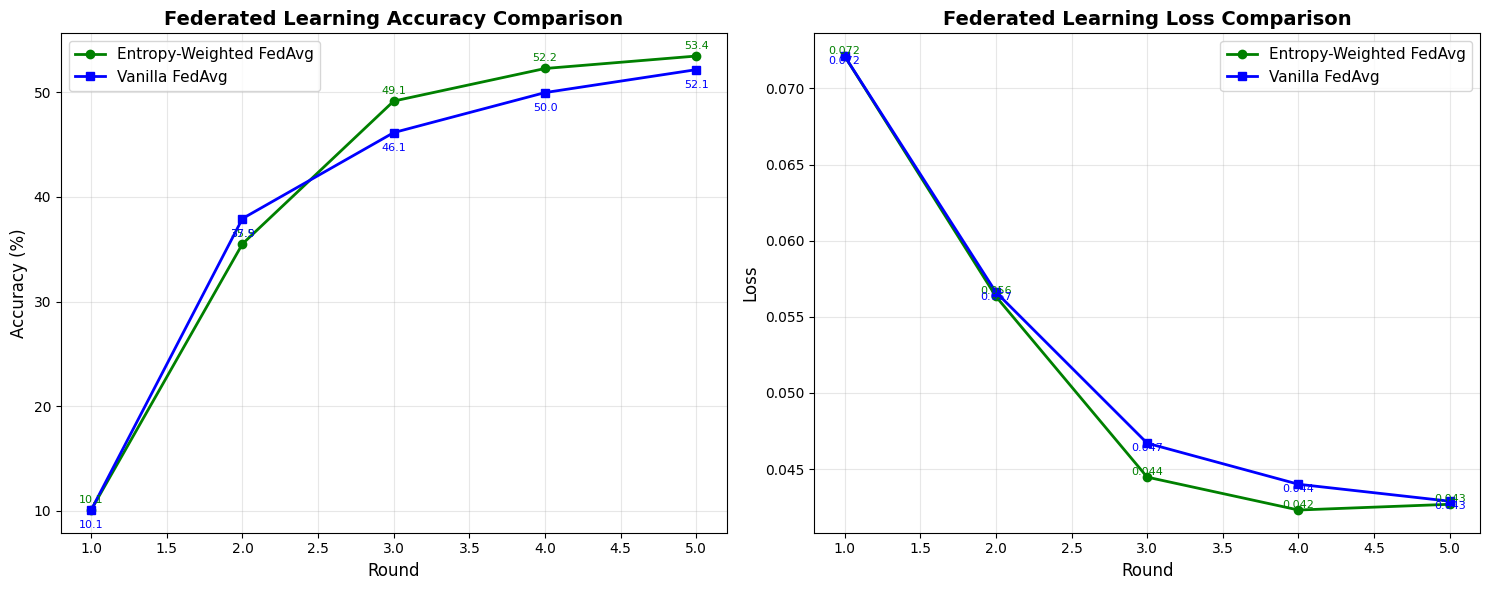


FEDERATED LEARNING COMPARISON SUMMARY
Final Accuracy:
  Entropy-Weighted FedAvg: 53.44%
  Vanilla FedAvg:          52.14%
  Improvement:             +1.30%

Final Loss:
  Entropy-Weighted FedAvg: 0.0427
  Vanilla FedAvg:          0.0429
  Improvement:             +0.0002


In [22]:
def create_comparison_plot():
    """Create a combined plot comparing Entropy-Weighted FedAvg vs Vanilla FedAvg."""

    # Load results from JSON files
    try:
        with open("results_vanilla_fedavg.json", "r") as f:
            entropy_results = json.load(f)

        with open("results_vanilla_fedavg_vanilla.json", "r") as f:
            vanilla_results = json.load(f)
    except FileNotFoundError:
        print("Error: Results files not found. Make sure both simulations have completed.")
        return

    # Extract data
    entropy_rounds = list(range(1, len(entropy_results["loss"]) + 1))
    vanilla_rounds = list(range(1, len(vanilla_results["loss"]) + 1))

    entropy_acc = [100.0 * metrics["accuracy"] for metrics in entropy_results["metrics"]]
    vanilla_acc = [100.0 * metrics["accuracy"] for metrics in vanilla_results["metrics"]]

    entropy_loss = entropy_results["loss"]
    vanilla_loss = vanilla_results["loss"]

    # Create the comparison plot
    plt.figure(figsize=(15, 6))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(entropy_rounds, entropy_acc, 'g-o', label='Entropy-Weighted FedAvg', linewidth=2, markersize=6)
    plt.plot(vanilla_rounds, vanilla_acc, 'b-s', label='Vanilla FedAvg', linewidth=2, markersize=6)




    # Add value annotations
    for x, y in zip(entropy_rounds, entropy_acc):
        plt.text(x, y + 0.5, f"{y:.1f}", ha='center', va='bottom', fontsize=8, color='green')
    for x, y in zip(vanilla_rounds, vanilla_acc):
        plt.text(x, y - 1.0, f"{y:.1f}", ha='center', va='top', fontsize=8, color='blue')

    plt.grid(True, alpha=0.3)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.xlabel("Round", fontsize=12)
    plt.title("Federated Learning Accuracy Comparison", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(entropy_rounds, entropy_loss, 'g-o', label='Entropy-Weighted FedAvg', linewidth=2, markersize=6)
    plt.plot(vanilla_rounds, vanilla_loss, 'b-s', label='Vanilla FedAvg', linewidth=2, markersize=6)

    # Add value annotations
    for x, y in zip(entropy_rounds, entropy_loss):
        plt.text(x, y, f"{y:.3f}", ha='center', va='bottom', fontsize=8, color='green')
    for x, y in zip(vanilla_rounds, vanilla_loss):
        plt.text(x, y, f"{y:.3f}", ha='center', va='top', fontsize=8, color='blue')

    plt.grid(True, alpha=0.3)
    plt.ylabel("Loss", fontsize=12)
    plt.xlabel("Round", fontsize=12)
    plt.title("Federated Learning Loss Comparison", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)

    plt.tight_layout()
    plt.savefig("federated_learning_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics
    print("\n" + "=" * 60)
    print("FEDERATED LEARNING COMPARISON SUMMARY")
    print("=" * 60)
    print(f"Final Accuracy:")
    print(f"  Entropy-Weighted FedAvg: {entropy_acc[-1]:.2f}%")
    print(f"  Vanilla FedAvg:          {vanilla_acc[-1]:.2f}%")
    print(f"  Improvement:             {entropy_acc[-1] - vanilla_acc[-1]:+.2f}%")
    print()
    print(f"Final Loss:")
    print(f"  Entropy-Weighted FedAvg: {entropy_loss[-1]:.4f}")
    print(f"  Vanilla FedAvg:          {vanilla_loss[-1]:.4f}")
    print(f"  Improvement:             {vanilla_loss[-1] - entropy_loss[-1]:+.4f}")
    print("=" * 60)


# Call the comparison plot function
create_comparison_plot()


![image.png](attachment:bb57c17e-84dc-4843-932c-879e615303bc.png)